# Perform a data-driven analysis of CLINC-150

CLINC-150 is a dataset proposed by [Larson et al.](https://paperswithcode.com/paper/an-evaluation-dataset-for-intent) in the goal of doing intent analysis with an `out-of-scope` intent. This last intent should be output by the model when no prediction can be made.
This is particularly important in intent classification as users often make unsupported requests. For example, you could go on any chatbot and enter "I would like some pizza". This is a valid sentence, but this is not part of the intents that we support. Hence, we should output `oos`.

Today, I would like to analyze this dataset and perform a data-driven analysis. To do so, I will use `sentence-transformers` to extract features and `spectral_metric` to perform a spectral analysis of the dataset.

I will keep this tutorial short, do not hesitate to reach out if you have questions.

**Note** This notebook should run as-is if you have `spectral_metric`, `seaborn` and `sentence-transformers` installed.


In [1]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

# We perform the analysis on the train set.
ds = load_dataset('clinc_oos', "small")["train"]
class_names = ds.features['intent'].names
# I use all-MiniLM-L12-v2 as it is a good compromise between speed and performance.
embedder = SentenceTransformer("all-MiniLM-L12-v2")

Reusing dataset clinc_oos (/home/fred/.cache/huggingface/datasets/clinc_oos/small/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
# Show dataset info
display(ds)

Dataset({
    features: ['text', 'intent'],
    num_rows: 7600
})

In [3]:
# We will get **normalized** features for the dataset using our embedder.
import torch
features = embedder.encode(ds['text'], device=0 if torch.cuda.is_available() else -1, normalize_embeddings=True)

### Running the spectral analysis

Now that we have our embeddings extracted by our sentence embedder, we can make an in-depth analysis of these features.

To do so, we will use CSG (Branchaud-Charron et al, 2019), a technique that combines Probability Product Kernels (Jebara et al, 2004) and spectral clustering to analyze a dataset without training a model. 

In this notebook, we won't use the actual CSG metrics, but we will use the $W$ matrix. 
This matrix is computed as:
* Run a Probabilistic K-NN on the dataset (optionally done via Monte-Carlo)
* Compute the average prediction per class (results in the $S$ matrix)
* Symetrize this matrix using Bray-Curtis distance metric, a metric that was made to compare samplings from a distribution.

These steps are all done by `spectral_metric.estimator.CumulativeGradientEstimator`.

In [16]:
# Let's compute the W matrix from Branchaud et al. and try to find overlapping classes.
from spectral_metric.estimator import CumulativeGradientEstimator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from spectral_metric.visualize import make_graph

X, y = features, np.array(ds['intent'])  # Your dataset with shape [N, ?], [N]
estimator = CumulativeGradientEstimator(M_sample=250, k_nearest=5, distance="cosine")
estimator.fit(data=X, target=y)

/data/workspace/spectral_metric/spectral_metric/lib.py:105: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(class_samples), class_indices


### Visualize the $W$ matrix

Now that we have a simitrized similarity matrix, we can run some analysis on it.
Here's what we will do:

1. Plot the matrix
2. Find the intent with the highest confusion (entropy)
3. Find the most similar pairs of classes.
4. Show the points in the dataset that contribute to this confusion.

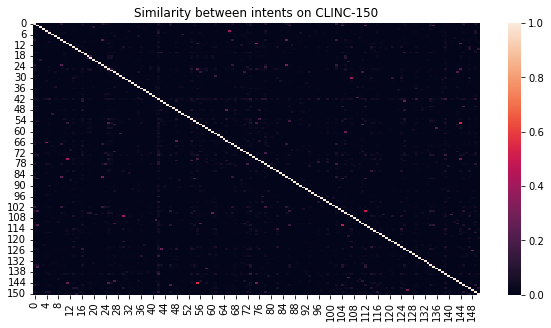

In [23]:
plt.figure(figsize=(10,5))
sns.heatmap(estimator.W)
plt.title("Similarity between intents on CLINC-150")
plt.show()

While this dataset has over 150 classes, we can find some pairs with high similarity (the red points the matrix).

Parsing this figure is hard with such an high amount of classes so we will need to dig down.

As a sanity check, we can compute the entropy of each row of the W matrix. We would expect the `oos` class to be the most "confused" and hence have the highest entropy.

In [15]:
from scipy.stats import entropy
import pandas as pd
entropy_per_class = entropy(estimator.W / estimator.W.sum(-1)[:, None], axis=-1)
print("Class that is the most confused (highest entropy):", class_names[np.argmax(entropy_per_class)])

Class that is the most confused (highest entropy): oos


In [7]:
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))[::-1]
pairs = [(i,j) for i,j in pairs if i != j]

In [13]:
print("Most similar pairs")
lst = []
for idx, (i,j) in enumerate(pairs[::2][:10]):
    lst.append({"Intent pair" : f"{class_names[i]} <> {class_names[j]}", "Similarity": estimator.W[i,j]})
print(pd.DataFrame(lst))

Most similar pairs
                                     Intent pair  Similarity
0             change_user_name <> change_ai_name       0.552
1                     recipe <> ingredients_list       0.492
2                 what_is_your_name <> user_name       0.412
3                                      yes <> no       0.388
4                               timezone <> time       0.384
5                        pto_balance <> pto_used       0.300
6  confirm_reservation <> restaurant_reservation       0.292
7          change_user_name <> what_is_your_name       0.284
8          shopping_list_update <> shopping_list       0.276
9                    calendar <> calendar_update       0.272


### Analysis

By looking at the top-10 most similar pairs, we get some good insights on the dataset. While this does not 100% indicates that the classifier trained downstream will have issues with this pair, we know that these intents are similar. In consequence, the classifier might not be able to separate the pair easily.

We can further investigate and look at the samples that contribute the most to this decision. Let's take the most similar pairs, `change_user_name <> change_ai_name` and `recipe <> ingredients_list` .

In [9]:
def show_most_confused(source_intent, target_intent, estimator, class_names):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    closest_to_second = np.argsort([sample[target_intent] for sample in estimator.samples[source_intent]])[::-1][:10]
    dataset_indices = estimator.class_indices[source_intent][closest_to_second]
    for di in dataset_indices:
        print("\t", ds[int(di)]["text"])
        
first_pair = pairs[0]    
show_most_confused(first_pair[0], first_pair[1], estimator, class_names)
show_most_confused(first_pair[1], first_pair[0], estimator, class_names)

print("-----------------------------")
second_pair = pairs[2]    
show_most_confused(second_pair[0], second_pair[1], estimator, class_names)
show_most_confused(second_pair[1], second_pair[0], estimator, class_names)

change_user_name <> change_ai_name
	 please change my name to loverboy
	 change my name to master
	 i need to change my username
	 please stop calling me dave, my name's bob
	 change the name that you call me
	 can i change my nickname
	 my name's bob
	 can i change what you call me
	 i'd like you to refer to me as bob
	 is there a way i can change the name you use to address me
change_ai_name <> change_user_name
	 i want to start calling you marie
	 i want to start calling you bob
	 from now, your new name will be lord vader
	 i'm calling you rupert from now on
	 change your name to ginger
	 if i may, i'd like to call you slave
	 how can i change your name
	 can i begin calling you dave
	 i want to change your name to another name
	 x is your new nickname
-----------------------------
recipe <> ingredients_list
	 how do i make the perfect omelette
	 how do i make lassagna
	 please show me a recipe for chili
	 how do you create pork chili
	 can you give me a recipe for german chocolate

From the top-5 most confused examples per pair, we can see that the sentences are quite similar.
While a human could easily separate the two intents, we see that the sentences are made of the same words which might confuse the classifier.

Some sentences could be seen as mislabelled. For example, in `ingredients_list` we have the sentence `"show me the recipe for broccoli cheddar soup"` which could be from the `recipe` intent.

Of course, these features come from a model that was not trained to separate these classes, they come from a general-purpose language model. The goal of this analysis is to give insights to the data scientist before they train an expensive model. If we were to train a model on this dataset, the model could probably handle the confusion between `ingredients_list` and `recipe` by fitting the word *ingredients* for the former and *recipe* for the latter.


## Conclusion

In this tutorial, we covered how to conduct a data-driven analysis for CLINC-150, an intent classification dataset. By using sentence embedding and the `spectral_metric` library, we found the intents that would be the most likely to be confused and a potential mislabelling problem between `ingredients_list` and `recipe`.

Following our analysis, we could take the following actions:
1. Upweight the intents `change_user_name` and `change_ai_name` during training for the model to better learn to separate them.
2. Merge `recipe` and `ingredients_list` as they are quite similar in intention.
3. Analyse other overlapping sentences to find mislabelled sentences.

If you have any questions, suggestions or ideas for this library please reach out:

1. frederic.branchaud.charron@gmail.com
2. [@Dref360 on Github](https://github.com/Dref360)


If you have a dataset that you think would be a good fit for this analysis let me know too!